In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.base
import taichi as ti
import klib as kl
import warnings
import os
import shap
from pickle import load

os.environ['KERAS_BACKEND']='tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'Kaiti'
plt.rcParams['axes.unicode_minus'] = False
PIC_PATH = "../models/solve2/"
ti.init(arch=ti.gpu)

[Taichi] version 1.1.2, llvm 10.0.0, commit f25cf4a2, win, python 3.9.7
[Taichi] Starting on arch=cuda


In [2]:
with open('../models/solve1_model.pkl', 'rb') as f:
    model = load(f)
model

RandomForestClassifier(n_estimators=25)

In [3]:
X = pd.read_csv('../data/solve1_X.csv', index_col=0)
y = pd.read_csv('../data/solve_y.csv', index_col=0)
X

,调和平均温度,扭矩转速积,机器质量等级,运行时间
0,301.799801,15864.8,0,213
1,300.958445,94107.0,1,89
2,300.858415,33142.0,0,149
3,301.603348,51849.2,1,151
4,301.603348,45946.6,2,154
...,...,...,...,...
8993,303.524111,47318.0,1,14
8994,303.575696,51897.6,2,17
8995,303.724161,54943.0,1,22
8996,303.772585,68288.0,2,25


In [4]:
import pydotplus
from sklearn.tree import export_graphviz

i = 0
for per in model.estimators_:
    dot_data = export_graphviz(per, out_file=None,
                         feature_names=X.columns,
                         class_names=['0','1'],
                         filled=True, rounded=True,
                         special_characters=True)

    dot_tree_val = dot_data.replace('helvetica', 'MicrosoftYaHei')
    graph = pydotplus.graph_from_dot_data(dot_tree_val)
    i = i+1
    graph.write_png(PIC_PATH + str(i) + 'tree.png')


(dot.exe:2220): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:23328): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:11396): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:7752): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:20432): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:11796): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


(dot.exe:19920): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-

In [5]:
explain = shap.TreeExplainer(model, X)
shap_value = explain.shap_values(X)
shap_value2 = explain(X)

 97%|=================== | 17403/17996 [00:21<00:00]       

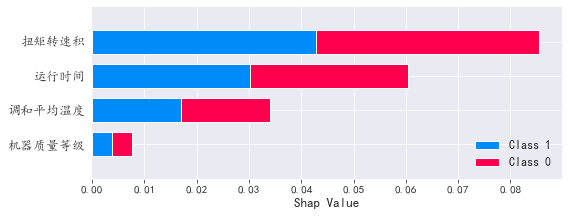

In [6]:
shap.summary_plot(shap_value, X, show=False)
plt.xlabel('Shap Value')
plt.tight_layout()
plt.savefig(PIC_PATH + 'feature impact.png', dpi=800)

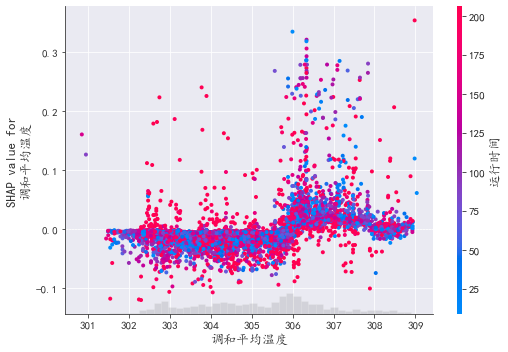

In [7]:
shap_value2.display_data = X.values
shap.plots.scatter(shap_value2[:, '调和平均温度'][:, 1], color=shap_value2[:, '运行时间'][:, 1], show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'temp-time-shap.png', dpi=800)

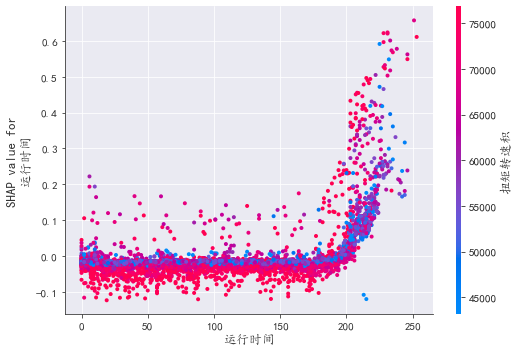

In [8]:
shap.dependence_plot("运行时间", shap_value[1], X, show=False)
plt.tight_layout()
plt.savefig(PIC_PATH + 'shap time-npm.png', dpi=800)

In [9]:
import lime
from lime import lime_tabular

explain_lime = lime_tabular.LimeTabularExplainer(
    training_data=X.to_numpy(),
    feature_names=X.columns,
    class_names=[0, 1],
    mode='classification'
)

In [10]:
plt.figure(figsize=(16, 9))
exp = explain_lime.explain_instance(data_row=X.iloc[0], predict_fn=model.predict_proba,
                                    num_features=4)
# exp.show_in_notebook()
exp.save_to_file(PIC_PATH + 'choice.png')

<Figure size 1152x648 with 0 Axes>

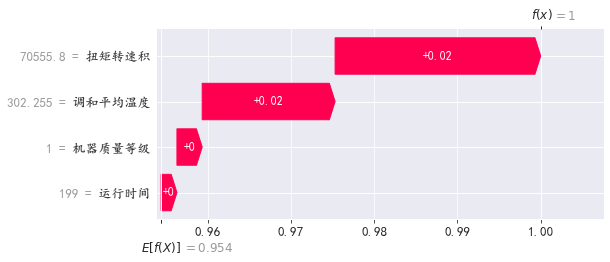

In [11]:
plt.rcParams['font.family'] = ['sans-serif']
plt.figure(figsize=(16, 9))
shap.plots.waterfall(shap_value2[100][:, 0])

In [13]:
data = pd.concat([X, y], axis=1)
data

,调和平均温度,扭矩转速积,机器质量等级,运行时间,target
0,301.799801,15864.8,0,213,1
1,300.958445,94107.0,1,89,1
2,300.858415,33142.0,0,149,1
3,301.603348,51849.2,1,151,0
4,301.603348,45946.6,2,154,0
...,...,...,...,...,...
8993,303.524111,47318.0,1,14,0
8994,303.575696,51897.6,2,17,0
8995,303.724161,54943.0,1,22,0
8996,303.772585,68288.0,2,25,0


In [15]:
class_group = data.groupby('target')

In [20]:
description = pd.DataFrame(index=pd.MultiIndex.from_product(
    [data['target'].unique().tolist(),
     ['调和平均温度', '扭矩转速积', '运行时间']]
))

def compute_cov(df):
    return df.std() / df.mean()

count = []
mean = []
median = []
maxin = []
cov = []
maxium = []
minin = []

for classes in data['target'].unique():
    _ = class_group.get_group(classes).drop(['机器质量等级', 'target'], axis=1)
    count.extend(_.count().tolist())
    mean.extend(_.mean().tolist())
    median.extend(_.median().tolist())
    maxin.extend(_.max() - _.min().tolist())
    cov.extend(compute_cov(_).tolist())
    maxium.extend(_.max().tolist())
    minin.extend(_.min().tolist())


description['count'] = count
description['mean'] = mean
description['median'] = median
description['cov'] = cov
description['maxin'] = maxin
description['max'] = maxium
description['min'] = minin

description

[301, 301, 301]
[301, 301, 301, 8697, 8697, 8697]


count          mean        median       cov         maxin  \
1 调和平均温度    301    305.705367    306.082378  0.005170      8.121621   
  扭矩转速积     301  69758.431894  72187.500000  0.248899  89013.600000   
  运行时间      301    144.093023    168.000000  0.507914    253.000000   
0 调和平均温度   8697    305.129973    305.200917  0.005262      7.580043   
  扭矩转速积    8697  59631.945889  59616.600000  0.163004  52358.700000   
  运行时间     8697    106.610095    106.000000  0.590007    246.000000   

                   max           min  
1 调和平均温度    308.980036    300.858415  
  扭矩转速积   99980.400000  10966.800000  
  运行时间      253.000000      0.000000  
0 调和平均温度    309.031543    301.451501  
  扭矩转速积   85924.800000  33566.100000  
  运行时间      246.000000      0.000000

In [21]:
description.to_excel('../data/solve1_description.xlsx')